In [1]:
suppressWarnings(library(tidyverse, warn.conflicts = FALSE))
suppressWarnings(library(lubridate, warn.conflicts = FALSE))
suppressWarnings(library(infer))
suppressWarnings(library(repr))
suppressWarnings(library(broom))
suppressWarnings(library(gridExtra))

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.2     v purrr   0.3.4
v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




# Predicting Vancouver Bicycle Thefts

STAT 201 Project Group 6

**By:** Benjamin Chang, Dennis Fan, Justin Kung, Selena Shew

## Introduction

The City of Vancouver aims to be on the leading edge of urban sustainability (City of Vancouver, 2020). As part of this strategy, the city encourages individuals to reduce their carbon footprints through sustainable commuting (e.g., public transport, biking, and sustainable driving). Of the three sustainable commuting options, biking has the lowest day-to-day carbon footprint. However, Vancouver is ranked as having the highest number of thefts per capita in Canada (Ballard, 2021) and potential cyclists rank fear of bike theft as one of the top deterrents (Agarwal & North, 2012).

Research on bike theft in Canada conducted in Montreal suggests bike theft peaks during summer months and that bikes are more frequently stolen during the night (Lierop van et al., 2015). This can inform when higher care to security should be exercised by bike owners. We seek to further investigate whether bike owners should exercise more care based on usage patterns (i.e., transportation to/from work vs. leisure). To obtain a first-order approximation to this question, we will investigate whether there is a meaningful difference between the mean daily bike thefts occurring on weekdays vs. weekends, using the typical workweek as a proxy for usage pattern.


The Crime Data from the Vancouver Police Department (VPD) (https://geodash.vpd.ca/opendata/) contains ~33,000 bike crime records between 2003 and 2021. This sample will help us draw inference to a population of all Vancouver bike thefts both in the past and in the future. 

Our main question is "Whether there exists a significant difference (alpha = 0.05) in the mean number of daily bike thefts between weekdays and weekends". To investigate this question, the difference in mean daily bike thefts will be our *variable of interest* and our *categories* are weekdays (M-F) vs. weekends (S-Su). Our parameter of interest would the difference in means between categories alongside the standard error to help understand the variability of our result.

This initial investigation can provide a high-level characterization of weekday crime vs weekend and further analysis can follow to obtain a detailed understanding using more specific drivers (e.g., times during weekdays vs weekends, neighbourhoods, etc.)

### Wrangling and Exploration of Data

In [2]:
# We first load the VPD Crime data by reading in CSV from the web
URL = "http://geodash.vpd.ca/opendata/crimedata_download/crimedata_csv_all_years.csv"
data = read_csv(URL, col_types = cols())
head(data)

TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Break and Enter Commercial,2012,12,14,8,52,NA,Oakridge,491285.0,5453433
Break and Enter Commercial,2019,3,7,2,6,10XX SITKA SQ,Fairview,490613.0,5457110
Break and Enter Commercial,2019,8,27,4,12,10XX ALBERNI ST,West End,491007.8,5459174
Break and Enter Commercial,2014,8,8,5,13,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2020,7,28,19,12,10XX ALBERNI ST,West End,491015.9,5459166
Break and Enter Commercial,2005,11,14,3,9,10XX ALBERNI ST,West End,491021.4,5459161


We first filter the crime type to only bike thefts. Following this, we create a new column called `weekend` with a boolean value indicating weekday/weekend. This is done by manipulating the `YEAR`, `MONTH` and `DAY` columns with some functionality from the `lubridate` library. We also filter to only include observations between 2003-2020 for reproducibility of analysis, since the VPD dataset is updated daily M-F at 10:30am.

In [3]:
bike_theft_data <- data %>%
    filter(TYPE == "Theft of Bicycle") %>% # Filter crime type to bike theft
    mutate(ymdsum = DAY + (MONTH * 100) + (YEAR * 10000)) %>% # Create helper columns to facilitate categorization of weekday vs weekend
    mutate(date = ymd(ymdsum)) %>% 
    mutate(day = wday(date)) %>%
    mutate(weekend = (day == 1 | day == 7)) %>% # Create column categorizing weekday (FALSE) and weekend (TRUE)
    filter(YEAR <= 2020) %>% # Filtering for before March 15, 2021 (Snapshot in time, 
                             # since we are working with live data)
    arrange(date)

# Select the parameters of interest, keeping some variables for context
bike_theft_data <- bike_theft_data[-c(2,3,4,5,6,7,8,9,10,11)]
head(bike_theft_data)

TYPE,date,day,weekend
<chr>,<date>,<dbl>,<lgl>
Theft of Bicycle,2003-01-01,4,FALSE
Theft of Bicycle,2003-01-01,4,FALSE
Theft of Bicycle,2003-01-01,4,FALSE
Theft of Bicycle,2003-01-01,4,FALSE
Theft of Bicycle,2003-01-02,5,FALSE
Theft of Bicycle,2003-01-03,6,FALSE


The data is summarized below. Points of highlight are the total reported incidents of bike theft (\~33,300) between the period 2003-2020. Approximately \~9300 thefts (\~28%) occurred over a weekend. This \~28% figure corresponds to slightly less than \~28.6% (2/7 based on the number of weekend days in a week), which may be an early indication that the effect size will be small in our investigation.

In [4]:
print("Table 1: Summary of raw observations from VPD GeoDash between 2003-2020")
summary(bike_theft_data)


[1] "Table 1: Summary of raw observations from VPD GeoDash between 2003-2020"


     TYPE                date                 day         weekend       
 Length:33316       Min.   :2003-01-01   Min.   :1.000   Mode :logical  
 Class :character   1st Qu.:2009-05-28   1st Qu.:2.000   FALSE:24043    
 Mode  :character   Median :2014-01-19   Median :4.000   TRUE :9273     
                    Mean   :2013-02-20   Mean   :4.002                  
                    3rd Qu.:2017-03-29   3rd Qu.:6.000                  
                    Max.   :2020-12-31   Max.   :7.000                  

To facilitate our hypothesis testing, the data is further converted into daily observations reflecting the number of bicycle thefts on each day (n = 6575 = number of days between \[2003-01-01, 2020-12-31]). We do this by joining the crime dataset to a tibble with all dates between 2003-2020 and replace NA values with 0 since the complete dataset did not have any missing dates (implying that no bike thefts occurred on dates ending up with NA values ~300).

In [5]:
# Wrangle data to obtain number of crimes on each date
daily_bike_theft <- bike_theft_data %>% 
    group_by(date) %>%
    summarise(thefts = n()) 

# Create a new dataframe with all dates between 2003 and 2020
daily_bike_crime_all_dates <- tibble(
    date = seq(as.Date("2003-01-01"), as.Date("2020-12-31"), by="days"))

# Merge complete date df and thefts dataframe, setting thefts to 0 for days with no crime logged 
daily_bike_crime_merged <- merge(x = daily_bike_crime_all_dates, y = daily_bike_theft, by = "date", all.x = TRUE)
daily_bike_crime_merged$thefts[is.na(daily_bike_crime_merged$thefts)] <- 0

# Re-introduce adjusted dataset
daily_bike_theft <- daily_bike_crime_merged %>% 
    mutate(day = wday(date)) %>% 
    mutate(weekend = (day == 1 | day == 7))

print("Table 2: Summary of consolidated daily theft data")
summary(daily_bike_theft)

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Table 2: Summary of consolidated daily theft data"


      date                thefts            day     weekend       
 Min.   :2003-01-01   Min.   : 0.000   Min.   :1   Mode :logical  
 1st Qu.:2007-07-02   1st Qu.: 2.000   1st Qu.:2   FALSE:4697     
 Median :2012-01-01   Median : 4.000   Median :4   TRUE :1878     
 Mean   :2012-01-01   Mean   : 5.067   Mean   :4                  
 3rd Qu.:2016-07-01   3rd Qu.: 7.000   3rd Qu.:6                  
 Max.   :2020-12-31   Max.   :30.000   Max.   :7                  

The data is visualized in aggregate through **Figure 1: Total number of bicycle thefts vs days of week** and **Figure 2: Boxplot of mean bike thefts by category** the average number of crimes between weekdays and weekends. Based on the boxplot, we observe that weekdays and weekends have similar means with similar standard deviations.

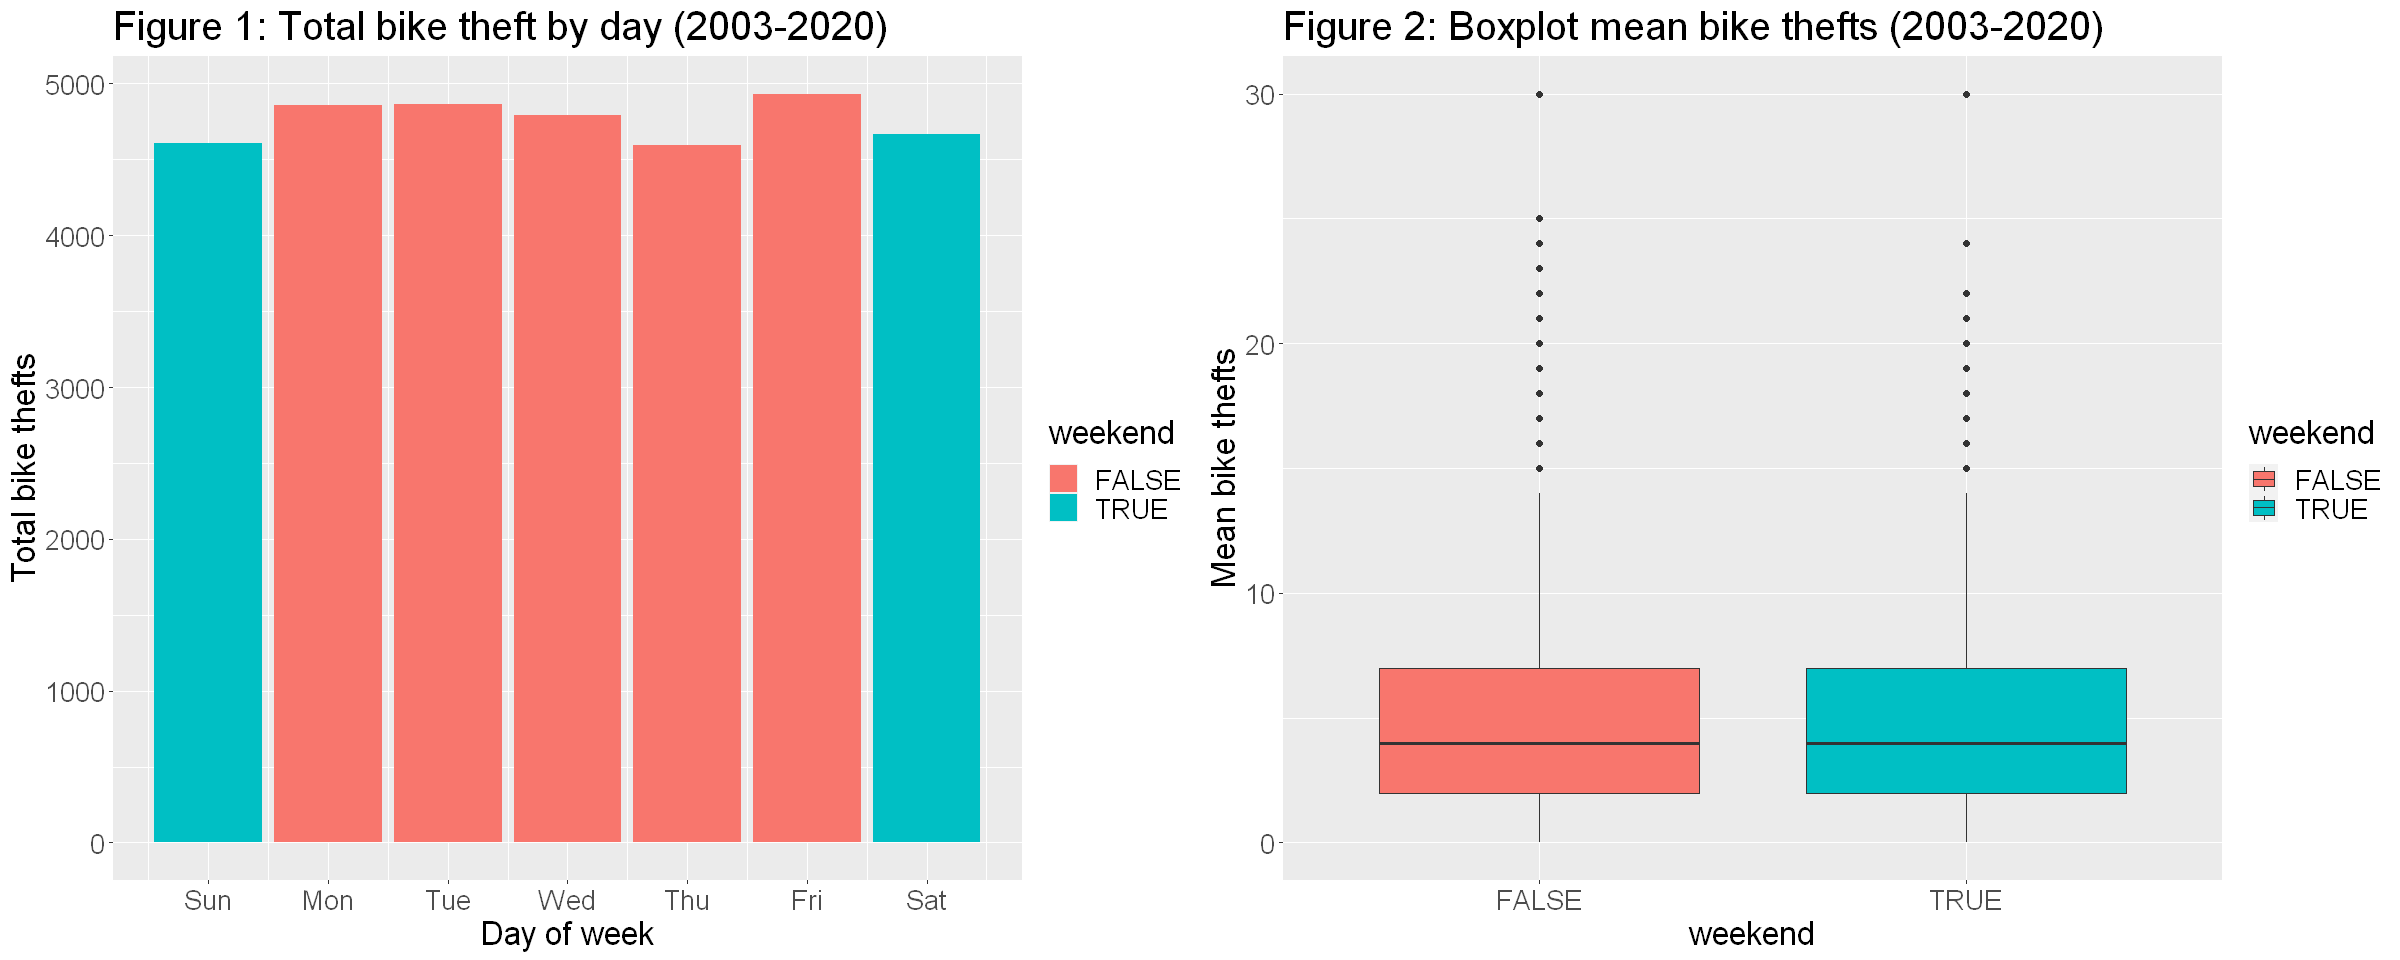

In [6]:
text_size <- 20
options(repr.plot.height = 8, repr.plot.width = 20)

# Bar plot to examine total crimes by day
total_by_days <- bike_theft_data %>%
    ggplot(aes(x = day, fill = weekend)) +
    geom_bar() + 
    scale_x_continuous(breaks=1:7, labels=c("Sun", "Mon","Tue","Wed","Thu","Fri","Sat")) +
    labs(x = "Day of week", y = "Total bike thefts", title = "Figure 1: Total bike theft by day (2003-2020)") +
    theme(text = element_text(size=text_size))

# Box plot to examine total crimes by day
mean_by_category <- daily_bike_theft %>% 
    ggplot(aes(x = weekend, y = thefts, fill = weekend)) + 
    geom_boxplot() + 
    ylab("Mean bike thefts") +
    ggtitle("Figure 2: Boxplot mean bike thefts (2003-2020)") +
    theme(text = element_text(size=text_size))

gridExtra::grid.arrange(total_by_days, mean_by_category, ncol = 2)  

To further understand the data, sample histograms are plotted in **Figure 3: Histogram of weekday thefts** and **Figure 4: Histogram of weekend thefts**. Based on the histograms, we see that both categories have similar shapes (unimodal right skew) and variability.

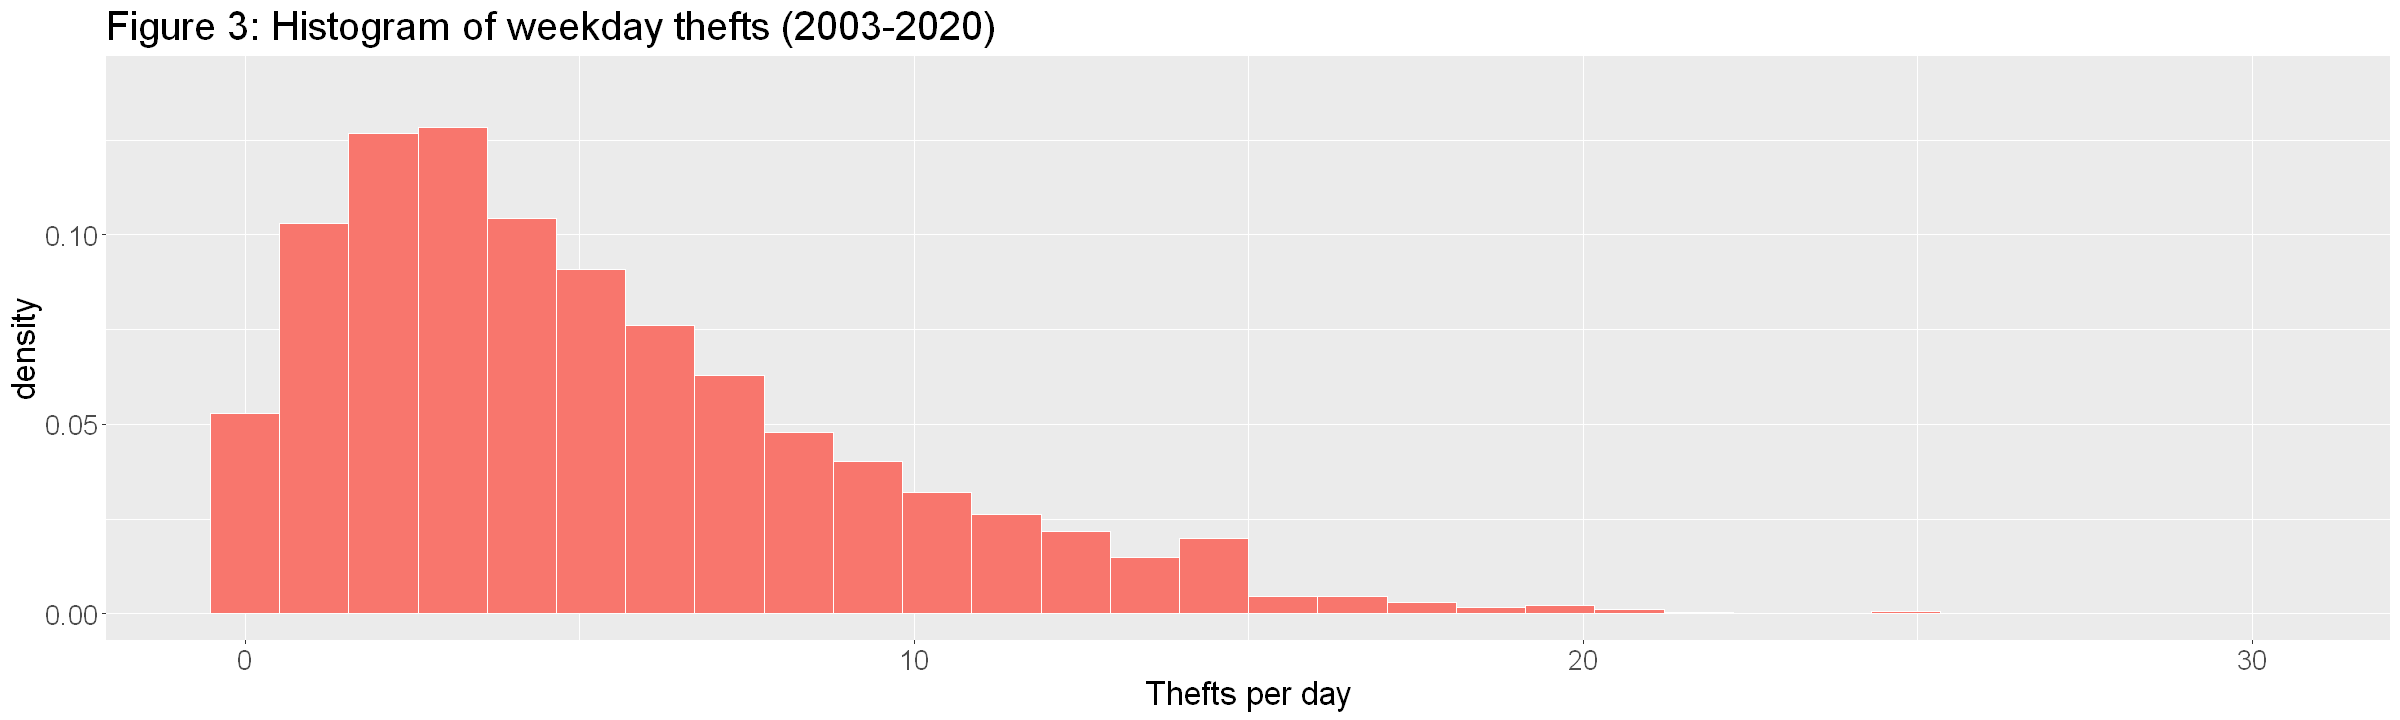

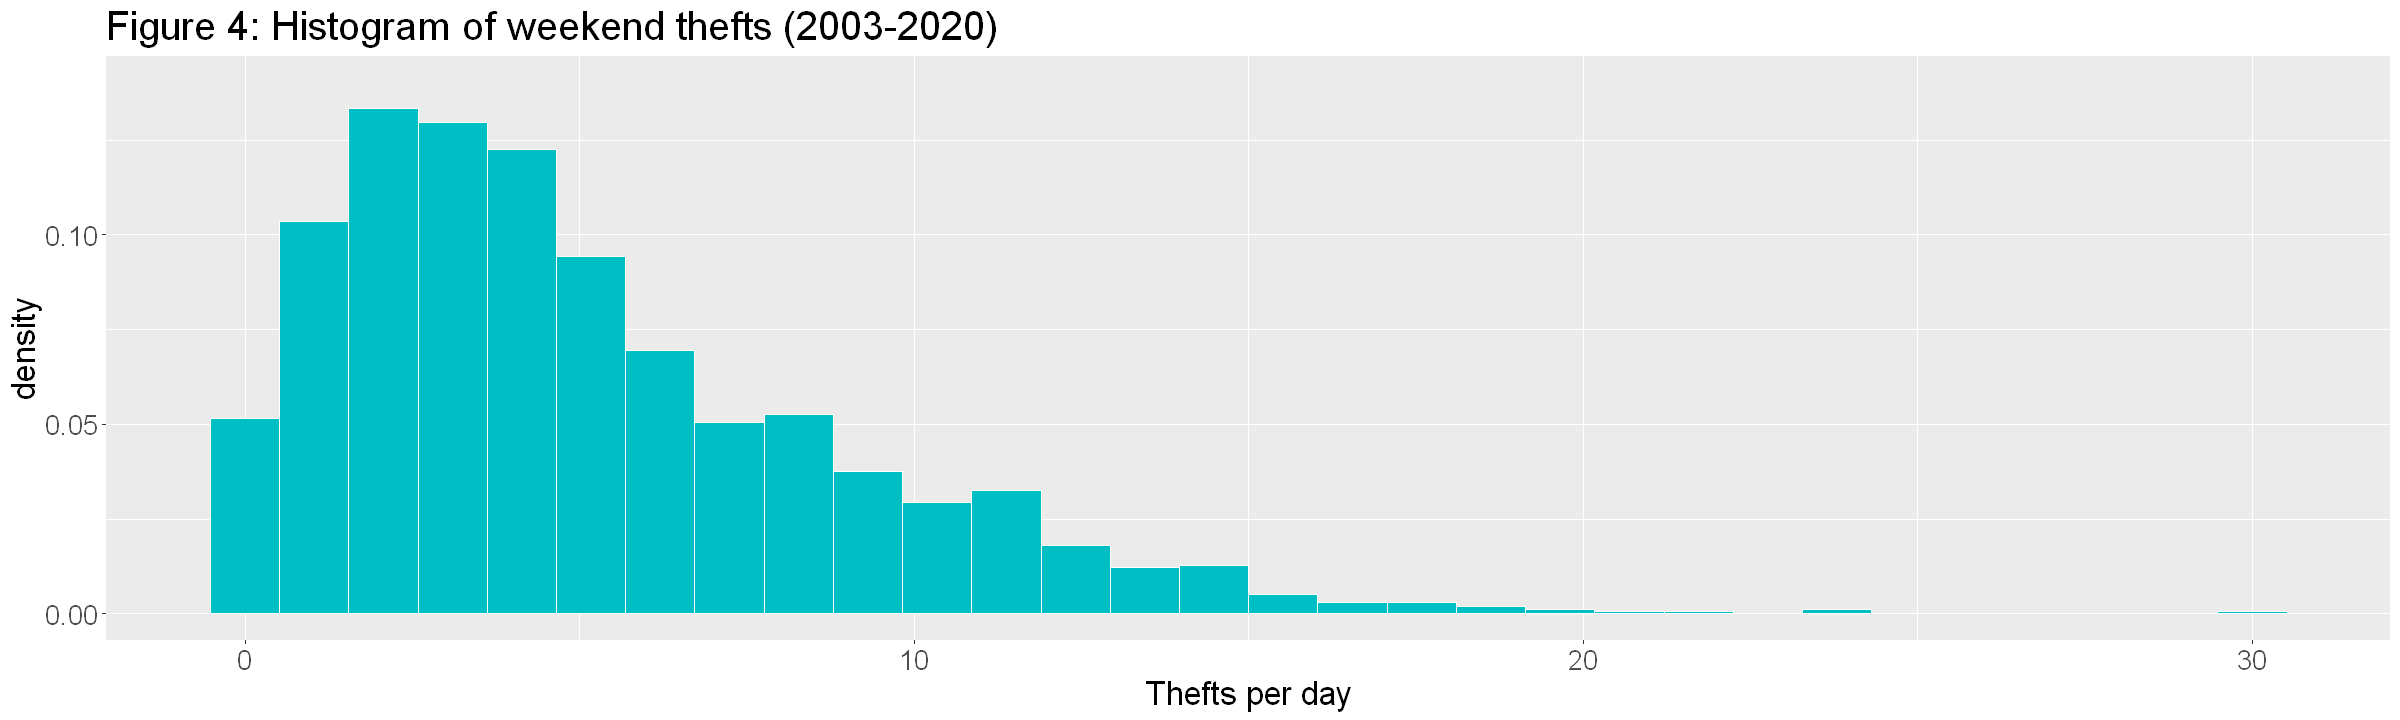

In [7]:
options(repr.plot.height = 6, repr.plot.width = 20)

# Weekday theft histogram
weekday_crime_histogram <- daily_bike_theft %>%
    filter(!weekend) %>% 
    ggplot() +
    geom_histogram(aes(x=thefts, y = ..density..), color = 'white', fill = '#F8766D', bins = 30) +
    ggtitle("Figure 3: Histogram of weekday thefts (2003-2020)") +
    xlab("Thefts per day") +
    scale_y_continuous(limits = c(0,0.14)) +
    theme(text = element_text(size = 20))
weekday_crime_histogram

# Weekend theft histogram
weekend_crime_histogram <- daily_bike_theft %>%
    filter(weekend) %>% 
    ggplot() +
    geom_histogram(aes(x=thefts, y = ..density..), color ='white', fill = '#00BFC4', bins = 30) +
    ggtitle("Figure 4: Histogram of weekend thefts (2003-2020)") +
    xlab("Thefts per day") +
    scale_y_continuous(limits = c(0,0.14)) +
    theme(text = element_text(size = 20))
weekend_crime_histogram

We can calculate our parameters of interest, the average bike thefts on weekdays and weekends, to arrive at our test statistic (the difference in mean daily thefts for weekdays vs. weekends).

In [8]:
grouped_by_weekend <- daily_bike_theft %>% 
    group_by(weekend) %>% 
    summarize(mean = mean(thefts))
grouped_by_weekend

obs_stat = grouped_by_weekend$mean[1] - grouped_by_weekend$mean[2]
print("Observed test statistic")
print(obs_stat)


`summarise()` ungrouping output (override with `.groups` argument)



weekend,mean
<lgl>,<dbl>
FALSE,5.118799
TRUE,4.937700


[1] "Observed test statistic"
[1] 0.1810996


## Methods

**Overview of Methodology**

Our test statistic is the difference between mean daily thefts occurring on weekdays vs. weekends. Mean daily thefts represent the average number of bike thefts per day. Each observation represents a single day, categorized as either a weekday (Monday - Friday) or a weekend (Saturday, Sunday).

To determine if there is a significant (alpha = 0.05) difference between the mean daily bike thefts occurring on weekdays vs. weekends (categorical variable), we first define our null hypothesis as the two categories having an equal number of average daily thefts.

\begin{equation}
H_0: \mu_{Weekday} - \mu_{Weekend} = 0
\end{equation}

Our alternate hypothesis is defined as there is a difference between the average number of bike thefts between categories.

\begin{equation}
H_A: \mu_{Weekday} - \mu_{Weekend} \neq 0
\end{equation}

These hypotheses are tested using three different methods in the following report: 1) bootstrapping and 2) CLT approximation with t-distribution. For each method, a test statistic, p-value, and 95% confidence interval are calculated. 

- The test statistic reflects the difference between means we observe based on our sample. Please note that this differs for the bootstrap method, which reflects the average observed difference from 5000 simulations (with replacement) of size 6575. 

- The p-value in each test should be interpreted as the probability of observing the above test statistic or one that is more extreme, assuming the null hypothesis is true.

- The confidence interval should be interpreted as the plausible range of values where the true parameter may lie. In other words, if we were to repeat the sampling process and calculate 95% confidence intervals each time and repeat this process many times, then 95% of the intervals would capture the population parameter’s value.


*Note: Our interpretations of the data include the following:*
- Classification of weekends as Saturday & Sunday, which does not reflect occasions such as statutory long weekends
- Date is interpreted as the true time when a theft was committed or the beginning time of when a theft was suspected of being committed (clarified through correspondence with VPD). One implication of this is that thefts may be over-represented on Fridays if users do not check their bikes between Friday and the next weekday use (Monday).

### 1. Bootstrap Method

Since we are inferring about a population that represents both past and future bike crimes, it is beneficial and justified to use all observations available to us as our sample. We have already wrangled and transformed our data during "Preliminary Analysis" into a form where each observation represents a single date and the number of bike thefts on that date (n = 6575). In addition, since our sample (and population) is likely not normally distributed, the bootstrap simulation lends well to this analysis since few assumptions need to be made.

In [9]:
# We can revisit the cleaned data frame from Preliminary Analysis
head(daily_bike_theft)
dim(daily_bike_theft)

,date,thefts,day,weekend
,<date>,<dbl>,<dbl>,<lgl>
1,2003-01-01,4,4,FALSE
2,2003-01-02,1,5,FALSE
3,2003-01-03,2,6,FALSE
4,2003-01-04,5,7,TRUE
5,2003-01-05,6,1,TRUE
6,2003-01-06,4,2,FALSE


[1] 6575    4

We can generate 5000 bootstrap replicates of size 6575 using the infer package, specifying our response variable as `thefts` our explanatory variable as `weekend`.

In [10]:
set.seed(6575)

bootstrap_infer_generate <- daily_bike_theft %>% 
    specify(formula = thefts ~ weekend) %>% 
    generate(reps = 5000, type = "bootstrap")

head(bootstrap_infer_generate)

replicate,thefts,weekend
<int>,<dbl>,<fct>
1,1,FALSE
1,6,FALSE
1,3,FALSE
1,3,FALSE
1,6,FALSE
1,4,FALSE


Following, this we can calculate the difference in means between the categories by specifying the `stat` and presenting the order subtraction in `order`. 

In [11]:
bootstrap_infer <- bootstrap_infer_generate %>% 
    calculate(stat = "diff in means", order = c(FALSE,TRUE))

head(bootstrap_infer)

replicate,stat
<int>,<dbl>
1,-0.07666129
2,0.17899484
3,-0.08661500
4,0.24231718
5,0.15036058
6,0.21820289


To caculate the average test statistic observed, we take the mean of the 5000 replicate test statistics. For the CI, we use `get_ci` specifying 95% confidence interval. Finally, to obtain the p-value, we can use the get_pvalue function, supplying the observed stat from our original sample and specifying that we are looking for a two-sided test based on our alternative hypothesis.

In [12]:
set.seed(6575)

# calculate confidence interval
bootstrap_infer_ci <- bootstrap_infer %>% 
    get_ci(level = 0.95, type = "percentile")

# calculate average observed stat (used to center null distribution later)
bootstrap_infer_ts <- mean(bootstrap_infer$stat)

# shift bootstrap distribution by mean to center around 0 (null hypothesis)
bootstrap_infer_null <- bootstrap_infer %>% 
    mutate(stat = stat - bootstrap_infer_ts)

# calculate p-value
bootstrap_infer_p <- bootstrap_infer_null %>% 
    get_pvalue(obs_stat, "two sided") # observed stat calculated in preliminary analysis from sample

# combine into a summary dataframe
bootstrap_infer_summary <- tibble(method = "bootstrap (infer)") %>% 
    mutate(ci_lower = bootstrap_infer_ci$lower_ci,
           ci_upper = bootstrap_infer_ci$upper_ci) %>% 
    mutate(p_value = bootstrap_infer_p$p_value)

print("Table 3: Summary of results from bootstrapping")
bootstrap_infer_summary

[1] "Table 3: Summary of results from bootstrapping"


method,ci_lower,ci_upper,p_value
<chr>,<dbl>,<dbl>,<dbl>
bootstrap (infer),-0.02697328,0.3891142,0.0884


Since the p-value we obtain of \~0.088 is greater than 0.05 we do not have enough evidence to reject the null hypothesis. This also aligns with our confidence interval of [-0.027, 0.389], which contains the null hypothesis of 0.

We can also visualize the null bootstrap distribution and our observed test statistic in **Figure 5** and the confidence interval with the bootstrap distribution in **Figure 6** using `visualize` from `infer` package.

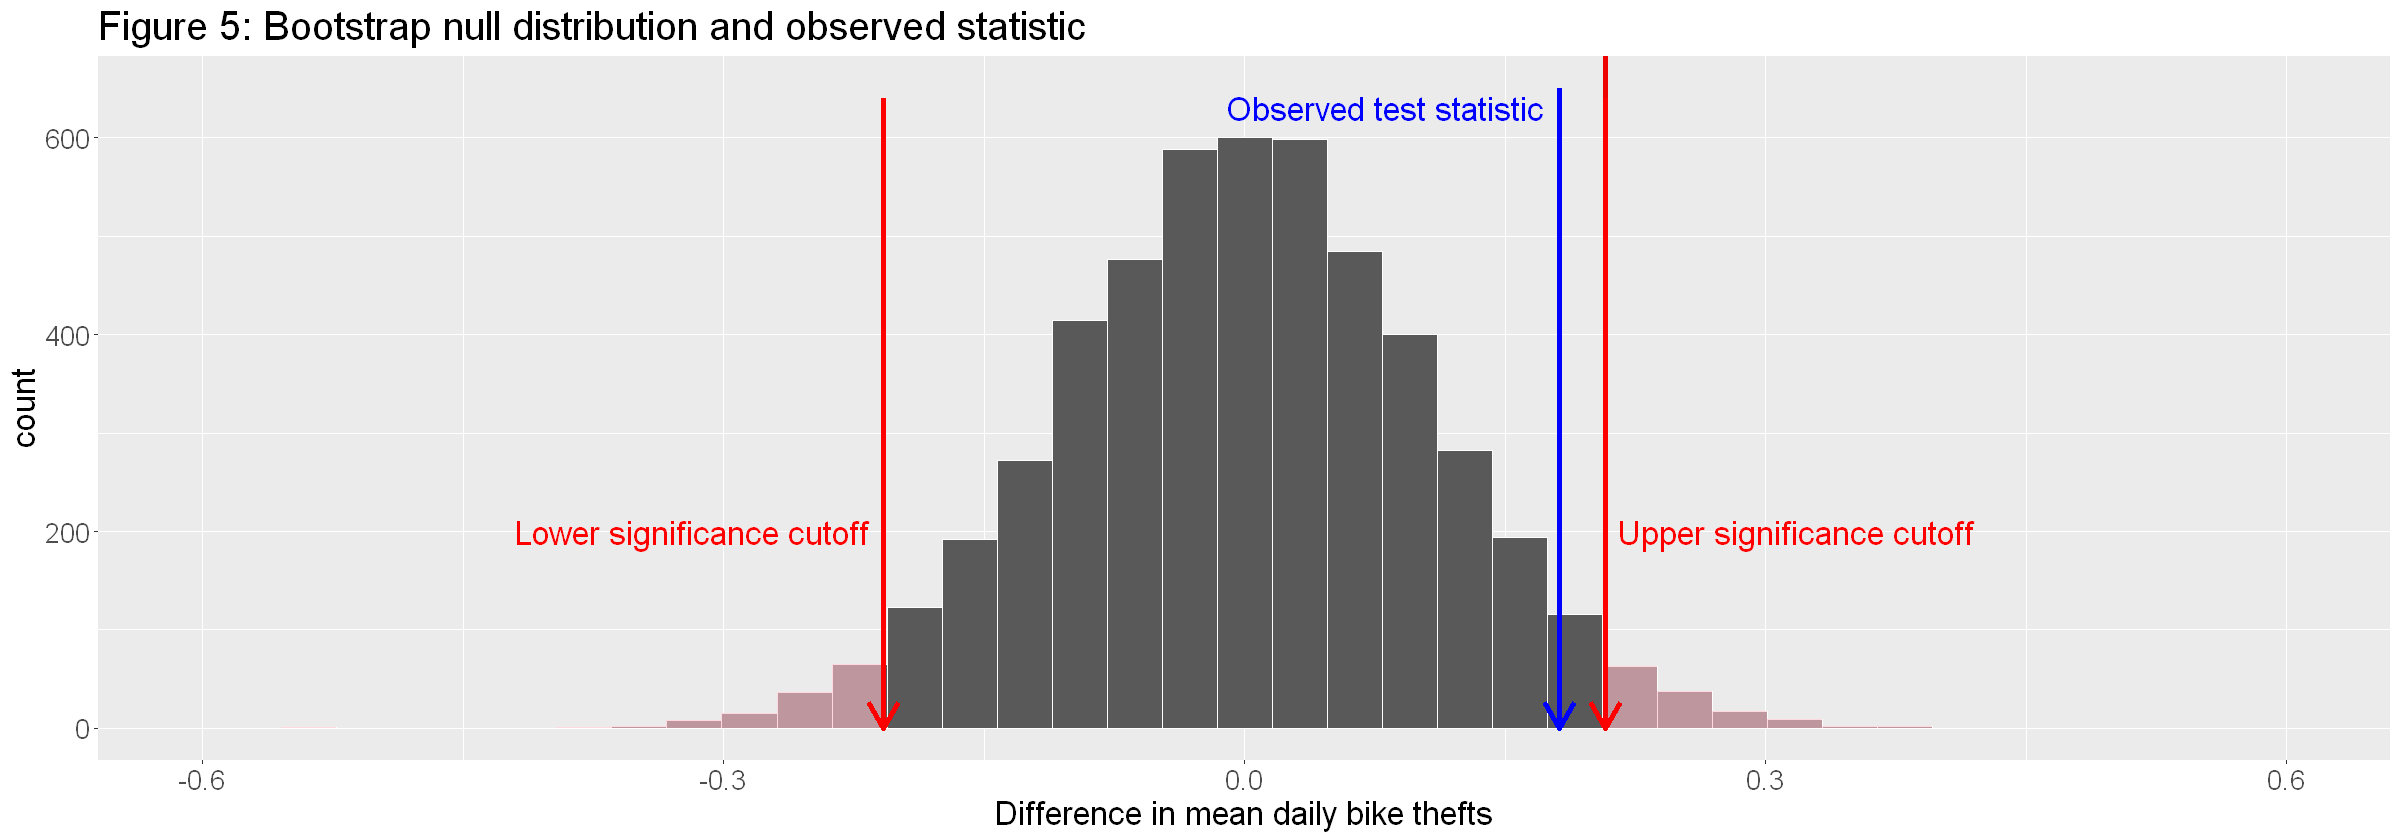

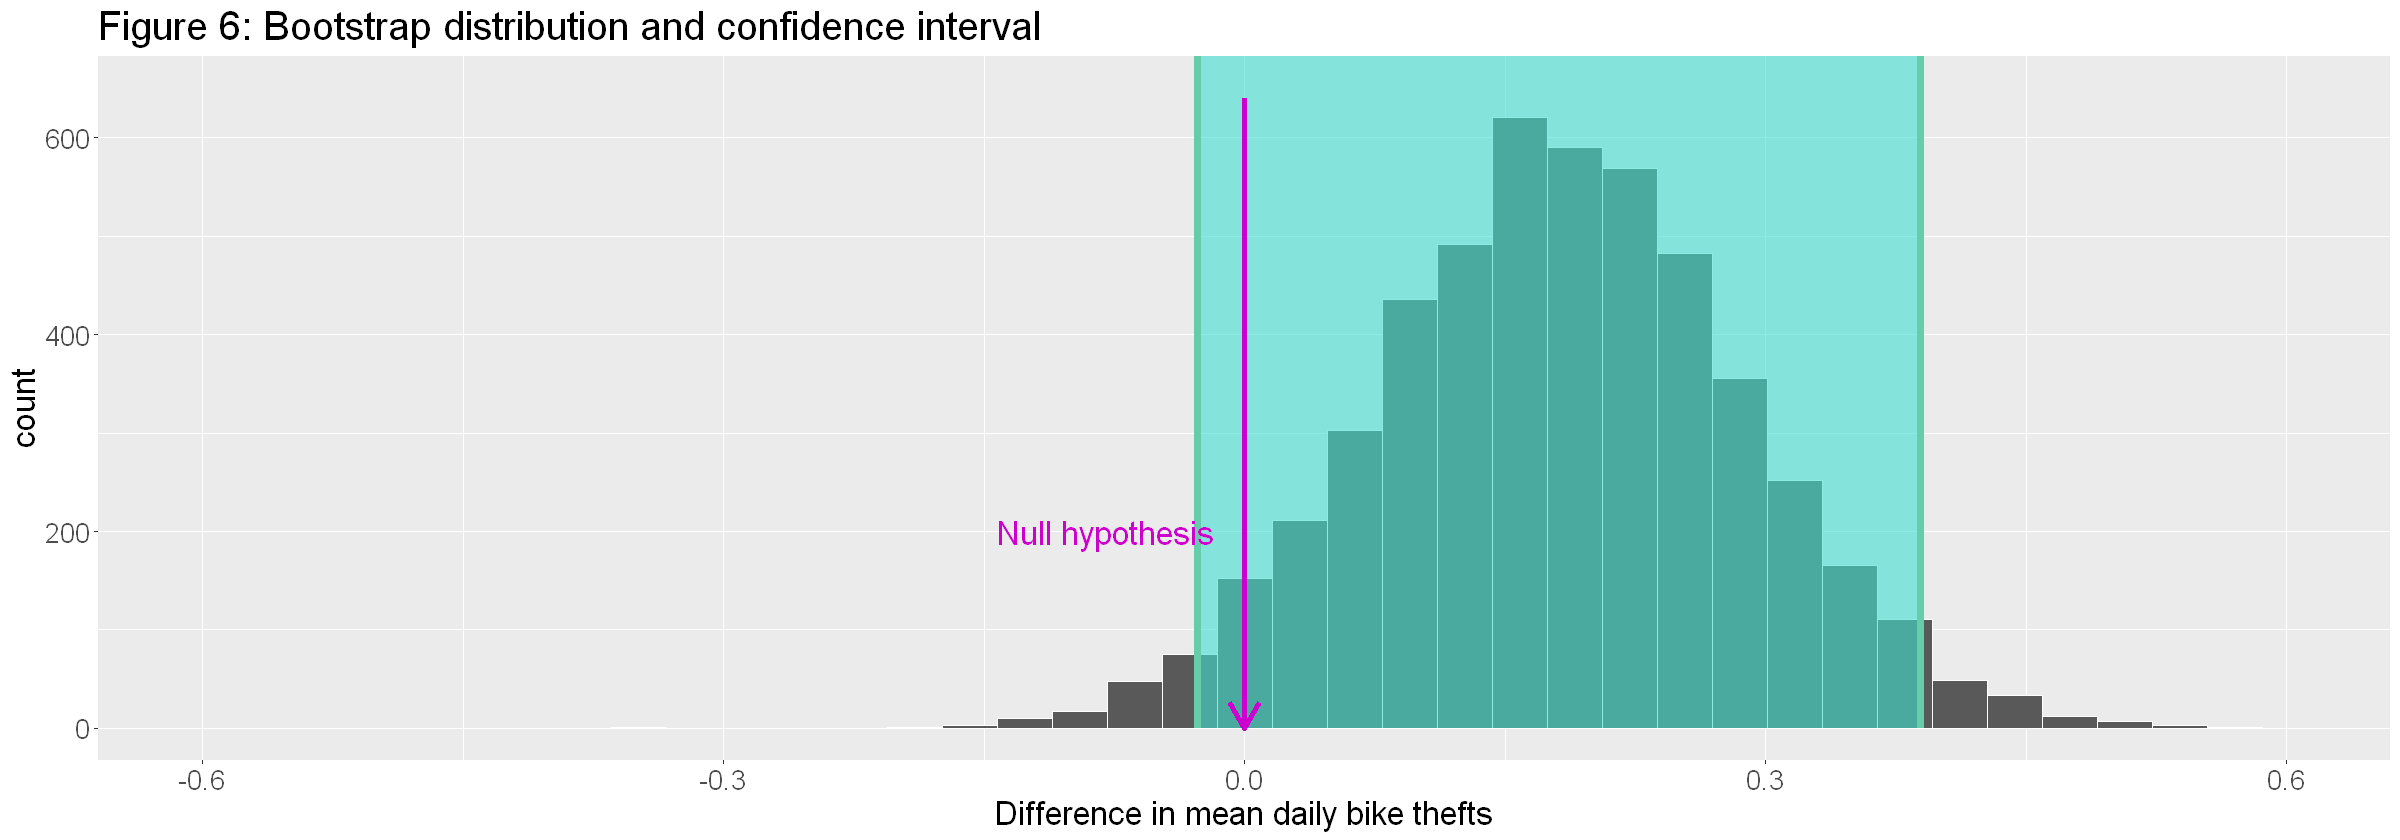

In [13]:
options(repr.plot.height = 7, repr.plot.width = 20)


bootstrap_p_cutoff_lower <- bootstrap_infer_null$stat %>% 
    quantile(prob = 0.025)

bootstrap_p_cutoff_upper <- bootstrap_infer_null$stat %>% 
    quantile(prob = 0.975)

bootstrap_infer_null_plot <- bootstrap_infer_null %>% 
    visualize(bins = 30) + 
    shade_p_value(obs_stat = bootstrap_p_cutoff_upper, direction = "both", size = 1.5) +
    annotate("text", x = bootstrap_p_cutoff_lower - 0.11, y = 200, 
             label = "Lower significance cutoff", color="red", size=7) +
    geom_segment(aes(x = bootstrap_p_cutoff_lower, y = 640, xend = bootstrap_p_cutoff_lower, yend = 0), 
                 arrow = arrow(), color = "red", size = 1.5) +
    annotate("text", x = bootstrap_p_cutoff_upper + 0.11, y = 200, 
             label = "Upper significance cutoff", color="red", size=7) +
    geom_segment(aes(x = bootstrap_p_cutoff_upper, y = 640, xend = bootstrap_p_cutoff_upper, yend = 0), 
                 arrow = arrow(), color = "red", size = 1.5) +
    annotate("text", x = obs_stat - 0.1, y = 630, label = "Observed test statistic", color="blue", size=7) +
    geom_segment(aes(x = obs_stat, y = 650, xend = obs_stat, yend = 0), 
                 arrow = arrow(), color = "blue", size = 1.5) +
    xlim(-0.6, 0.6) +
    ylim(-0, 650) +
    theme(text = element_text(size=20)) +
    xlab("Difference in mean daily bike thefts") +
    ggtitle("Figure 5: Bootstrap null distribution and observed statistic")
bootstrap_infer_null_plot

bootstrap_infer_ci_plot <- bootstrap_infer %>% 
    visualize(bins = 30) + 
    shade_confidence_interval(endpoints = bootstrap_infer_ci) +
    geom_segment(aes(x = 0, y = 640, xend = 0, yend = 0), 
                 arrow = arrow(), color = "magenta3", size = 1.5) +
    annotate("text", x = 0 - 0.08, y = 200, label = "Null hypothesis", color="magenta3", size=7) +
    xlim(-0.6, 0.6) +
    ylim(-0, 650) +
    theme(text = element_text(size=20)) +
    xlab("Difference in mean daily bike thefts") +
    ggtitle("Figure 6: Bootstrap distribution and confidence interval")

bootstrap_infer_ci_plot

### 2. CLT with T-distribution

To further explore our bootstrap results, we conducted a t-test for the difference in means between weekdays and weekends using the `infer` package's t.test function. We would expect the t-test results to be similar to the normal approximation, as our sample has sufficient degrees of freedom such that the t-distribution would converge to a normal distribution (we include the normal approximation calculation in Appendix A2).

To use the CLT approximation, we first check against the following assumptions:
1. **The sample is sufficiently large** - our dataset contains ~6500 observations, which is greater than 50.
1. **The sample is drawn in an independent fashion** - it is likely that bike theft is reported in an independent fashion, however, there may also be underreporting of bike thefts if the value of the bike is below a certain threshold.
2. **The sample size is <10% of the population size** - we are drawing inference on the population of all bike theft in Vancouver both in the past and future, therefore the population can be considered to be very large.
3. **The estimator is a sum of random components** - we are using the difference in means, which is a sum of random components.

We first subset our weekdays and weekend samples into separate vectors. These vectors are supplied to the t.test function along with our confidence interval of 95% and specification of a two-sided test (based on our alternative hypothesis).

In [14]:
# we can also use the built-in package for t_distribution

weekdays_vector <- daily_bike_theft$thefts[!daily_bike_theft$weekend]
weekends_vector <- daily_bike_theft$thefts[daily_bike_theft$weekend]

clt_t_test <- 
    tidy(
        t.test(x = weekdays_vector,
               y = weekends_vector,
               alternative = "two.sided", # specify parameter of test
               conf.level = 0.95))        # specify confidence interval 
clt_t_test

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1810996,5.118799,4.9377,1.721758,0.08519987,3574.156,-0.02512502,0.3873241,Welch Two Sample t-test,two.sided


The t-test yields a slightly lower p-value and tighter confidence interval. This is still congruent with our bootstrap findings and does not change our emerging conclusion to not reject the null hypothesis.

In [15]:
clt_t_summary <- tibble(method = "CLT (T-dist)") %>%
    mutate(test_statistic = clt_t_test$estimate,
           ci_lower = clt_t_test$conf.low,
           ci_upper = clt_t_test$conf.high,
           p_value = clt_t_test$p.value)

tests_summary <- bind_rows(bootstrap_infer_summary, clt_t_summary)
tests_summary

method,ci_lower,ci_upper,p_value,test_statistic
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
bootstrap (infer),-0.02697328,0.3891142,0.08840000,NA
CLT (T-dist),-0.02512502,0.3873241,0.08519987,0.1810996


### 3. Comparison of Methods and Conclusions

In [16]:
print("Table 3: Summary of findings from Bootstrap and CLT")
tests_summary

[1] "Table 3: Summary of findings from Bootstrap and CLT"


method,ci_lower,ci_upper,p_value,test_statistic
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
bootstrap (infer),-0.02697328,0.3891142,0.08840000,NA
CLT (T-dist),-0.02512502,0.3873241,0.08519987,0.1810996


Based on our findings for the test statistic, 95% confidence interval, and p-value across 1) bootstrapping and 2) CLT with t-dist approximation, we conclude that there is insufficient evidence to reject the null hypothesis. Both tests yielded p-values greater than our Type I error threshold of 5% and both confidence intervals included the null hypothesis of there being no difference between average daily theft rates on weekdays vs weekends.

A conservative interpretation would be to use the bootstrap results, which is more conservative (both for p-value and CI). The bootstrap method also requires fewer assumptions to be made about the sample and population than asymptotic approximations, since bootstrapping uses simulations on the raw data. 

Based on the above, we deem the bootstrap to be more reliable. Using the bootstrap results, we can report the 95% confidence interval to be within [\~-0.027, 0.389] and the p-value of our observed statistic under our null hypothesis to be ~0.088. Based on this, we cannot reject our null hypothesis of there being no difference in the average daily bike thefts between weekdays vs. weekends.

### Discussion

Our p-value of 0.088 was higher than our set confidence level of 0.05, which indicates that there is insufficient evidence to say that the mean number of bike thefts on the weekend differs from the weekdays based on our sample size. This may suggest that the public should still be aware and alert of bike crime risk both on weekdays and weekends. Furthermore, the public should be instructed to secure their bikes and take steps to prevent theft with instructions to do so readily available on all days.

Our study solely focuses on bike thefts, and public agencies could benefit greatly from investigating the implications of other crimes and how they are affected by the weekday to weekend shift. 

Building a stronger response to bike thefts requires a deep dive into how other variables affect the mean number of thefts. From the dataset provided, further questions such as how regionality, time of day, or events (such as COVID-19) impact bike theft rates. These further studies with covariates could shed light on how smarter systems to combat theft can be set up.

Furthermore, research into how these other factors impact differences between weekday vs. weekend crime rates could be beneficial. With the additional consideration of regionality, geospatial analysis can be used to further determine the correlation between locations and the occurrence of crime. While statistical analysis usually aims to eliminate complications brought upon by spatial autocorrelation, determining whether the mean number of crimes per location differs from other locations may help with identifying places of greatest concern in order to allocate resources efficiently. An example follow-up question for further analysis could be asking whether the mean number of bike thefts on a Friday night in the Downtown Eastside area differs significantly from the same time at UBC (exploring conventional biases).

### References

1. Agarwal, A., & North, A. (2012). Encouraging Bicycling among University Students: Lessons from Queen’s University, Kingston, Ontario. Canadian Journal of Urban Research, 21(1), 151–168. http://www.jstor.org/stable/26193886
2. Ballard, J. (2021, February 4). Vancouver still has the most bike thefts per capita among major Canadian cities, despite efforts | CBC News. CBC. https://www.cbc.ca/news/canada/british-columbia/vancouver-still-has-the-most-bike-thefts-per-capita-among-major-canadian-cities-despite-efforts-1.5898575
3. City of Vancouver. (2020). Greenest City Action Plan. https://vancouver.ca/green-vancouver/greenest-city-action-plan.aspx
4. Lierop van, D., Grimsrud, M., & El-Geneidy, A. (2015). Breaking into bicycle theft: Insights from Montreal, Canada. International Journal of Sustainable Transportation.

# APPENDIX

## A1: Manual Bootstrap Distribution Generation

### A1.1. Generate Bootstrap Replicates

We begin bootstrapping by taking 5000 re-samples with replacement of size 6575, to create 5000 simulations of our original dataset.

In [17]:
set.seed(6575)

size <- nrow(daily_bike_theft) # sample size of each bootstrap, equal to original size of samples
reps <- 5000 # number of reps

bike_bootstrap <- daily_bike_theft %>%
    rep_sample_n(size = size, reps = reps, replace = TRUE)

head(bike_bootstrap)
dim(bike_bootstrap)

replicate,date,thefts,day,weekend
<int>,<date>,<dbl>,<dbl>,<lgl>
1,2008-03-21,1,6,FALSE
1,2007-02-06,6,3,FALSE
1,2012-12-19,3,4,FALSE
1,2020-03-16,3,2,FALSE
1,2017-10-03,6,3,FALSE
1,2007-10-11,4,5,FALSE


[1] 32875000        5

With the bootstrapped samples, we can group by ‘replicate’ and ‘weekend’ to summarize the average number of daily bike thefts across weekends and weekdays, observed in each replicate sample.

In [18]:
bike_bootstrap_summary <- bike_bootstrap %>% 
    group_by(replicate, weekend) %>% 
    summarize(avg_daily_crime = mean(thefts))
head(bike_bootstrap_summary)

`summarise()` regrouping output by 'replicate' (override with `.groups` argument)



replicate,weekend,avg_daily_crime
<int>,<lgl>,<dbl>
1,FALSE,4.956798
1,TRUE,5.033459
2,FALSE,5.043366
2,TRUE,4.864371
3,FALSE,5.080961
3,TRUE,5.167576


To obtain our test statistic for each replicate, we again group by 'replicate' and use mutate() to add an additional column called ‘difference’ which contains the test statistic for each replicate. This difference between the mean daily bike thefts between weekends and weekdays is calculated using the lag() function, which would subtract the value of the average daily crime of weekdays from weekends for each replicate. 

Since the difference column only stored one test statistic for each observation, we can use filter to remove redundant rows (e.g., where weekend is FALSE) and select only the relevant replicate and difference columns.

We are then left with a single data frame containing only the replicate number and its corresponding test statistic, which is saved in `bike_bootstrap_summary`.

In [19]:
bike_bootstrap_summary <- bike_bootstrap %>% 
    group_by(replicate, weekend) %>% 
    summarize(avg_daily_crime = mean(thefts))  %>% # calculate mean daily bike thefts
    group_by(replicate) %>% 
    mutate(difference = lag(avg_daily_crime) - avg_daily_crime) %>% # calculate test statistic for each replicate
    filter(weekend == TRUE) %>% # remove redundant rows
    select(replicate, difference) %>% # select relevant columns
    ungroup()

head(bike_bootstrap_summary)
dim(bike_bootstrap_summary)

`summarise()` regrouping output by 'replicate' (override with `.groups` argument)



replicate,difference
<int>,<dbl>
1,-0.07666129
2,0.17899484
3,-0.08661500
4,0.24231718
5,0.15036058
6,0.21820289


[1] 5000    2

### A1.2. Calculate Bootstrap Confidence Interval

To calculate the confidence interval, we can use the quantile function alongside with the lower and upper bounds for our 95% confidence interval [0.025, 0.975] to determine the bounds for our test statistics. Based on this, we can say with 95% confidence that the true parameter falls between the range of \~-0.027 and \~0.389. This difference covers our null hypothesis of 0, which would lead us to not reject the null in favor of the alternative hypothesis.

In [20]:
# creating the bootstrap CI
bootstrap_ci <- bike_bootstrap_summary %>%
    summarise(ci_lower = quantile(difference, 0.025),
              ci_upper = quantile(difference, 0.975)) %>% 
    mutate(method = "bootstrap")
bootstrap_ci

ci_lower,ci_upper,method
<dbl>,<dbl>,<chr>
-0.02697328,0.3891142,bootstrap


### A1.3. Calculate p-value

To calculate the p-value, we first shift our bootstrap distribution by the mean bootstrap test statistic to simulate the null distribution (centered around 0).

In [21]:
# creating the bootstrap CI

bootstrap_ts <- mean(bike_bootstrap_summary$difference) # average of observed difference from each replicate

bootstrap_null <- bike_bootstrap_summary %>% 
    mutate(null_ts = difference - bootstrap_ts) # shifting our bootstrap distribution to center around 0 (H0)

head(bootstrap_null)

replicate,difference,null_ts
<int>,<dbl>,<dbl>
1,-0.07666129,-0.257850731
2,0.17899484,-0.002194605
3,-0.08661500,-0.267804445
4,0.24231718,0.061127736
5,0.15036058,-0.030828864
6,0.21820289,0.037013448


We can then use the bootstrap null distribution to obtain the proportion of replicates that are as extreme or more than our observed test statistic. The proportion obtained is then doubled since we are performing a two-sided test to obtain our p-value (based on our definition of the alternative hypothesis).

In [22]:
observed_stat <- obs_stat
replicates <- nrow(bootstrap_null)

bootstrap_p <- sum(bootstrap_null$null_ts >= observed_stat) / replicates * 2

print("Bootstrap p-value")
bootstrap_p

[1] "Bootstrap p-value"


[1] 0.0884

Summarizing the bootstrap findings, we combine our findings above into a neat tibble.


In [23]:
bootstrap_summary <- tibble(method = "bootstrap") %>% 
    left_join(bootstrap_ci) %>% 
    mutate(p_value = bootstrap_p)
bootstrap_summary


Joining, by = "method"



method,ci_lower,ci_upper,p_value
<chr>,<dbl>,<dbl>,<dbl>
bootstrap,-0.02697328,0.3891142,0.0884


## A2: CLT Analysis Using Normal Approximation

To use the CLT approximation, we first check against the following assumptions:
1. **The sample is drawn in an independent fashion** - it is likely that bike theft is reported in an independent fashion, however there may also be underreporting of bike thefts if the value of the bike is below a certain threshold.
2. **The sample size is <10% of the population size** - we are drawing inference on the population of all bike theft in Vancouver both in the past and future, therefore the population can be considered to be very large.
3. **The estimator is a sum of random components** - we are using the difference in means, which is a sum of random components.

We begin with the same dataframe `daily_bike_theft` as our sample and add the mean and sample standard error for each categorical variable.

In [24]:
n <- nrow(daily_bike_theft) #6575

clt_bike_theft <- daily_bike_theft %>% 
    group_by(weekend) %>% 
    # we then add the mean and standard error for weekdays (FALSE) and weekends (TRUE)
    summarize(mean = mean(thefts), std_error = sd(thefts)/sqrt(n()))

head(clt_bike_theft)

`summarise()` ungrouping output (override with `.groups` argument)



weekend,mean,std_error
<lgl>,<dbl>,<dbl>
FALSE,5.118799,0.05767846
TRUE,4.937700,0.08795819


To obtain the confidence interval, we must first calculate the test statistic (the difference in means) and combined standard error (root of the squares of the standard errors) to obtain the characteristics describing the normal approximation for our test statistic.

In [25]:
sample <- clt_bike_theft

weekday_mean <- sample$mean[1] # weekday sample mean
weekend_mean <- sample$mean[2] # weekend sample mean
diff_mean <- weekday_mean - weekend_mean # calculate the test statistic

weekday_se <- sample$std_error[1] # weekday
weekend_se <- sample$std_error[2] # weekend
comb_se <- sqrt(weekday_se^2 + weekend_se^2)  # calculate the combined standard error

print("Test statistic")
print(diff_mean)
print("Combined standard error")
print(comb_se)

[1] "Test statistic"
[1] 0.1810996
[1] "Combined standard error"
[1] 0.1051829


We can then determine the confidence interval using the quantile function for a normal distribution, supplying the parameters `diff_mean` and the combined standard error `comb_se` to describe the distribution of the test statistic.

In [26]:
ci_percent <- 0.95

lower_bound = (1 - ci_percent) / 2 # calculate lower bound of confidence interval (0.025)
upper_bound = (1 - lower_bound) # calculate lower bound of confidence interval (0.975)

clt_ci <- tibble(method = "CLT (Normal)") %>% 
    mutate(test_statistic = diff_mean) %>% 
    mutate(ci_lower = qnorm(lower_bound, diff_mean, comb_se),
           ci_upper = qnorm(upper_bound, diff_mean, comb_se))

clt_ci

method,test_statistic,ci_lower,ci_upper
<chr>,<dbl>,<dbl>,<dbl>
CLT (Normal),0.1810996,-0.02505519,0.3872543


To calculate the p-value, we can center our normal distribution at 0 and determine the area under the curve that is as extreme or more than our observed test statistic. This value is then doubled to reflect both tails covered under our alternative hypothesis.

In [27]:
clt_p <- pnorm(obs_stat, 0, comb_se, lower.tail = FALSE) * 2
print("CLT p-value")
print(clt_p)

[1] "CLT p-value"
[1] 0.08511334


In [28]:
clt_normal_summary <- clt_ci %>% 
    mutate(p_value = clt_p)

tests_summary <- bind_rows(bootstrap_summary, bootstrap_infer_summary, clt_t_summary,clt_normal_summary)
tests_summary

method,ci_lower,ci_upper,p_value,test_statistic
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
bootstrap,-0.02697328,0.3891142,0.08840000,NA
bootstrap (infer),-0.02697328,0.3891142,0.08840000,NA
CLT (T-dist),-0.02512502,0.3873241,0.08519987,0.1810996
CLT (Normal),-0.02505519,0.3872543,0.08511334,0.1810996


Our result from the CLT using normal approximation is very similar to our bootstrap and t-test results. All tests indicate that the null hypothesis should not be rejected under a 5% significance level (since the p-value is larger) and 95% confidence interval (since the CI includes the null hypothesis of 0). 